Inter-Annotator Agreement Analysis
Comparing Human vs LLM Role Annotations
This notebook calculates inter-annotator agreement between human and LLM annotations for the 'role' column.


In [35]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score, accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)

In [11]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 50)
pd.set_option('display.width', None)

# === ADJUST THESE PATHS ===
HUMAN_PATH = '../result/human/optimized_annotations_SHORT_human.csv'
LLM_PATH = '../result/flattened-by-expression/short/optimized_annotations_SHORT.csv'

# Load human annotations
human_df = pd.read_csv(HUMAN_PATH)
print(f"Human annotations: {human_df.shape[0]} rows, {human_df.shape[1]} columns")

# Load LLM annotations
llm_df = pd.read_csv(LLM_PATH)
print(f"LLM annotations: {llm_df.shape[0]} rows, {llm_df.shape[1]} columns")

Human annotations: 50 rows, 13 columns
LLM annotations: 50 rows, 29 columns


In [12]:
# Human annotation columns
print("Human annotation columns:")
print(list(human_df.columns))
print("_"*50)
# LLM annotation columns
print("LLM annotation columns:")
print(list(llm_df.columns))

Human annotation columns:
['thesis_code', 'section', 'sentence', 'expression_number', 'expression', 'is_reflexive', 'scope_classification', 'L1_classification', 'L2_classification', 'L3_classification', 'L3_borderline', 'L1_borderline_is', 'L2_borderline_is']
__________________________________________________
LLM annotation columns:
['thesis_code', 'section', 'sentence', 'expression_number', 'expression', 'is_reflexive', 'reflexivity_type', 'reflexivity_reasoning', 'scope_classification', 'scope_reach', 'scope_reasoning', 'L1_classification', 'L1_reasoning', 'L2_classification', 'L2_reasoning', 'L3_classification', 'L3_borderline', 'L3_reasoning', 'L1_borderline_is', 'L1_borderline_dominant', 'L1_borderline_secondary', 'L1_borderline_why', 'L2_borderline_is', 'L2_borderline_primary', 'L2_borderline_secondary', 'L2_borderline_tertiary', 'L2_borderline_strength', 'L2_borderline_why', 'comprehensive_justification']


## Compare and Align Columns (CREATING UID)
We keep only columns that exist in the human annotations (our reference).

In [13]:
# Find column differences
human_cols = set(human_df.columns)
llm_cols = set(llm_df.columns)

common_cols = human_cols & llm_cols
only_in_human = human_cols - llm_cols
only_in_llm = llm_cols - human_cols

print(f"Common columns: {len(common_cols)}")
print(f"Only in human: {len(only_in_human)}")
print(f"Only in LLM: {len(only_in_llm)}")

Common columns: 13
Only in human: 0
Only in LLM: 16


In [16]:
# Columns only in LLM (will be dropped)
if only_in_llm:
    print("Columns in LLM but NOT in Human (will be dropped):")
    for col in sorted(only_in_llm):
        print(f"  - {col}")
else:
    print("No extra columns in LLM")
print("_"*50)
# Columns only in human (missing from LLM)
if only_in_human:
    print("Columns in Human but NOT in LLM (missing):")
    for col in sorted(only_in_human):
        print(f"  - {col}")
else:
    print("No missing columns in Human code")

Columns in LLM but NOT in Human (will be dropped):
  - L1_borderline_dominant
  - L1_borderline_secondary
  - L1_borderline_why
  - L1_reasoning
  - L2_borderline_primary
  - L2_borderline_secondary
  - L2_borderline_strength
  - L2_borderline_tertiary
  - L2_borderline_why
  - L2_reasoning
  - L3_reasoning
  - comprehensive_justification
  - reflexivity_reasoning
  - reflexivity_type
  - scope_reach
  - scope_reasoning
__________________________________________________
No missing columns


In [18]:
# Keep only human columns (in same order)
cols_to_keep = [col for col in human_df.columns if col in llm_cols]

human_aligned = human_df[cols_to_keep].copy()
llm_aligned = llm_df[cols_to_keep].copy()

print(f"Aligned human: {human_aligned.shape}")
print(f"Aligned LLM: {llm_aligned.shape}")
print(f"\nColumns kept: {cols_to_keep}")

Aligned human: (50, 13)
Aligned LLM: (50, 13)

Columns kept: ['thesis_code', 'section', 'sentence', 'expression_number', 'expression', 'is_reflexive', 'scope_classification', 'L1_classification', 'L2_classification', 'L3_classification', 'L3_borderline', 'L1_borderline_is', 'L2_borderline_is']


In [19]:
# Examine key columns in both datasets

# --- is_reflexive ---
print("IS_REFLEXIVE Distribution:")
print("-" * 40)
print("Human:")
print(human_aligned['is_reflexive'].value_counts())
print("\nLLM:")
print(llm_aligned['is_reflexive'].value_counts())

# --- scope_classification ---
print("\n" + "=" * 40)
print("SCOPE_CLASSIFICATION Distribution:")
print("-" * 40)
print("Human:")
print(human_aligned['scope_classification'].value_counts())
print("\nLLM:")
print(llm_aligned['scope_classification'].value_counts())

# --- L1_classification ---
print("\n" + "=" * 40)
print("L1_CLASSIFICATION Distribution:")
print("-" * 40)
print("Human:")
print(human_aligned['L1_classification'].value_counts())
print("\nLLM:")
print(llm_aligned['L1_classification'].value_counts())

# --- L2_classification ---
print("\n" + "=" * 40)
print("L2_CLASSIFICATION Distribution:")
print("-" * 40)
print("Human:")
print(human_aligned['L2_classification'].value_counts(dropna=False))
print("\nLLM:")
print(llm_aligned['L2_classification'].value_counts(dropna=False))

# --- L3_classification ---
print("\n" + "=" * 40)
print("L3_CLASSIFICATION Distribution:")
print("-" * 40)
print("Human:")
print(human_aligned['L3_classification'].value_counts(dropna=False))
print("\nLLM:")
print(llm_aligned['L3_classification'].value_counts(dropna=False))

IS_REFLEXIVE Distribution:
----------------------------------------
Human:
is_reflexive
True     25
False    25
Name: count, dtype: int64

LLM:
is_reflexive
False    28
True     22
Name: count, dtype: int64

SCOPE_CLASSIFICATION Distribution:
----------------------------------------
Human:
scope_classification
MICRO    27
MESO     13
MACRO    10
Name: count, dtype: int64

LLM:
scope_classification
MICRO    28
MESO     11
MACRO    11
Name: count, dtype: int64

L1_CLASSIFICATION Distribution:
----------------------------------------
Human:
L1_classification
MD      45
PROP     5
Name: count, dtype: int64

LLM:
L1_classification
MD      47
PROP     3
Name: count, dtype: int64

L2_CLASSIFICATION Distribution:
----------------------------------------
Human:
L2_classification
INT_ACTIVE      37
INT_ACTIONAL     8
NaN              5
Name: count, dtype: int64

LLM:
L2_classification
INT_ACTIVE      39
INT_ACTIONAL     8
NaN              3
Name: count, dtype: int64

L3_CLASSIFICATION Distributi

In [6]:
# Align datasets - this assumes both datasets have some common identifier

def align_annotations(human_df, llm_df, id_column=None):
    """
    Align human and LLM annotations based on a common identifier.
    If no id_column is specified, assumes same order and length.
    """
    if human_df is None or llm_df is None:
        return None, None

    if id_column and id_column in human_df.columns and id_column in llm_df.columns:
        # Merge on common identifier
        merged = pd.merge(human_df, llm_df, on=id_column, suffixes=('_human', '_llm'))
        return merged['role_human'], merged['role_llm']
    else:
        # Assume same order and length
        min_len = min(len(human_df), len(llm_df))
        return human_df['role'][:min_len], llm_df['role'][:min_len]

# Aligning the data based on sentence (adjust id_column as needed)

human_roles, llm_roles = align_annotations(human_df, llm_df, id_column=None)

if human_roles is not None and llm_roles is not None:
    print(f"Aligned dataset size: {len(human_roles)}")
    print(f"Sample alignment check:")
    comparison_df = pd.DataFrame({
        'Human': human_roles.head(10),
        'LLM': llm_roles.head(10)
    })
    print(comparison_df)
else:
    print("Could not align the datasets. Please check data loading and column names.")

Aligned dataset size: 25
Sample alignment check:
           Human            LLM
0  Metadiscourse  Metadiscourse
1  Metadiscourse  Metadiscourse
2     Borderline     Borderline
3  Metadiscourse     Borderline
4  Metadiscourse     Borderline
5  Metadiscourse     Borderline
6  Metadiscourse  Metadiscourse
7  Metadiscourse     Borderline
8     Borderline  Metadiscourse
9     Borderline  Metadiscourse


In [20]:
# Columns to use for unique ID
id_cols = ['thesis_code', 'section', 'sentence', 'expression_number']

# Create UID
human_aligned['uid'] = human_aligned[id_cols].astype(str).agg('|'.join, axis=1)
llm_aligned['uid'] = llm_aligned[id_cols].astype(str).agg('|'.join, axis=1)

print("Sample UIDs:")
print(human_aligned['uid'].head())

Sample UIDs:
0    AP1|Introduction|Below, Figure 1.1 visualises ...
1    AP1|Introduction|Below, Figure 1.1 visualises ...
2    AP1|Introduction|Below, Figure 1.1 visualises ...
3    AP1|Introduction|Finally, the structure of the...
4    AP1|Introduction|Finally, the structure of the...
Name: uid, dtype: object


In [21]:
# Check for duplicates
human_dups = human_aligned['uid'].duplicated().sum()
llm_dups = llm_aligned['uid'].duplicated().sum()

print(f"Duplicate UIDs in human: {human_dups}")
print(f"Duplicate UIDs in LLM: {llm_dups}")

Duplicate UIDs in human: 0
Duplicate UIDs in LLM: 0


In [22]:
human_uids = set(human_aligned['uid'])
llm_uids = set(llm_aligned['uid'])

common_items = human_uids & llm_uids
only_human = human_uids - llm_uids
only_llm = llm_uids - human_uids

print(f"Items in human: {len(human_uids)}")
print(f"Items in LLM: {len(llm_uids)}")
print(f"Common items: {len(common_items)}")
print(f"Only in human: {len(only_human)}")
print(f"Only in LLM: {len(only_llm)}")

Items in human: 50
Items in LLM: 50
Common items: 50
Only in human: 0
Only in LLM: 0


In [23]:
# Merge on UID
merged = pd.merge(
    human_aligned,
    llm_aligned,
    on='uid',
    suffixes=('_human', '_llm'),
    how='inner'
)

print(f"Merged dataset: {merged.shape[0]} rows, {merged.shape[1]} columns")

Merged dataset: 50 rows, 27 columns


In [24]:
# Preview merged data
merged.head()

,thesis_code_human,section_human,sentence_human,expression_number_human,expression_human,is_reflexive_human,scope_classification_human,L1_classification_human,L2_classification_human,L3_classification_human,L3_borderline_human,L1_borderline_is_human,L2_borderline_is_human,uid,thesis_code_llm,section_llm,sentence_llm,expression_number_llm,expression_llm,is_reflexive_llm,scope_classification_llm,L1_classification_llm,L2_classification_llm,L3_classification_llm,L3_borderline_llm,L1_borderline_is_llm,L2_borderline_is_llm
0,AP1,Introduction,"Below, Figure 1.1 visualises this:",1,Below,True,MICRO,MD,INT_ACTIVE,Endophoric Marker,False,False,False,"AP1|Introduction|Below, Figure 1.1 visualises ...",AP1,Introduction,"Below, Figure 1.1 visualises this:",1,Below,True,MICRO,MD,INT_ACTIVE,Endophoric Marker,False,False,False
1,AP1,Introduction,"Below, Figure 1.1 visualises this:",2,Figure 1.1,True,MICRO,MD,INT_ACTIVE,Endophoric Marker,False,False,False,"AP1|Introduction|Below, Figure 1.1 visualises ...",AP1,Introduction,"Below, Figure 1.1 visualises this:",2,Figure 1.1,True,MICRO,MD,INT_ACTIVE,Endophoric Marker,False,False,False
2,AP1,Introduction,"Below, Figure 1.1 visualises this:",3,this,True,MESO,MD,INT_ACTIVE,Endophoric Marker,False,False,False,"AP1|Introduction|Below, Figure 1.1 visualises ...",AP1,Introduction,"Below, Figure 1.1 visualises this:",3,this,True,MESO,MD,INT_ACTIVE,Endophoric Marker,False,False,False
3,AP1,Introduction,"Finally, the structure of the overall thesis w...",1,Finally,True,MESO,MD,INT_ACTIVE,Frame Marker,False,False,False,"AP1|Introduction|Finally, the structure of the...",AP1,Introduction,"Finally, the structure of the overall thesis w...",1,Finally,True,MESO,MD,INT_ACTIVE,Frame Marker,False,False,False
4,AP1,Introduction,"Finally, the structure of the overall thesis w...",2,the structure of the overall thesis will be ex...,True,MACRO,MD,INT_ACTIVE,Frame Marker,False,False,False,"AP1|Introduction|Finally, the structure of the...",AP1,Introduction,"Finally, the structure of the overall thesis w...",2,the structure of the overall thesis will be ex...,True,MACRO,MD,INT_ACTIVE,Frame Marker,False,False,False


In [25]:
# Find columns that have both _human and _llm versions
comparison_cols = []
for col in merged.columns:
    if col.endswith('_human'):
        base = col.replace('_human', '')
        if f"{base}_llm" in merged.columns:
            comparison_cols.append(base)

print("Columns available for IAA comparison:")
for col in comparison_cols:
    print(f"  - {col}")

Columns available for IAA comparison:
  - thesis_code
  - section
  - sentence
  - expression_number
  - expression
  - is_reflexive
  - scope_classification
  - L1_classification
  - L2_classification
  - L3_classification
  - L3_borderline
  - L1_borderline_is
  - L2_borderline_is


In [26]:
print("="*50)
print("SUMMARY")
print("="*50)
print(f"Human annotations: {len(human_df)} items")
print(f"LLM annotations: {len(llm_df)} items")
print(f"Matched for comparison: {len(merged)} items")
print(f"\nVariables for IAA:")
for col in comparison_cols:
    if col not in ['thesis_code', 'section', 'sentence', 'expression_number', 'expression']:
        print(f"  • {col}")

SUMMARY
Human annotations: 50 items
LLM annotations: 50 items
Matched for comparison: 50 items

Variables for IAA:
  • is_reflexive
  • scope_classification
  • L1_classification
  • L2_classification
  • L3_classification
  • L3_borderline
  • L1_borderline_is
  • L2_borderline_is


### It's time to calculate IAA, F1 score, and Confusion Matrix

## 1. Confusion Matrix + F1 Score

In [33]:
# ============================================
# IS_REFLEXIVE: Confusion Matrix + F1 Score
# ============================================
# from sklearn.metrics import cohen_kappa_score, confusion_matrix, precision_score, recall_score, f1_score

print("=" * 60)
print("IS_REFLEXIVE: Full Analysis")
print("=" * 60)

human_col = merged['is_reflexive_human'].astype(str)
llm_col = merged['is_reflexive_llm'].astype(str)

# --- Basic Agreement ---
agree = (human_col == llm_col).sum()
total = len(merged)
pct = agree / total * 100

print(f"\nAgreement: {agree}/{total} = {pct:.1f}%")

# --- Cohen's Kappa ---
kappa = cohen_kappa_score(human_col, llm_col)
print(f"Cohen's κ: {kappa:.3f}")

# --- Confusion Matrix ---
print("\n" + "-" * 40)
print("CONFUSION MATRIX")
print("-" * 40)
print("                  Human=False  Human=True")
cm = confusion_matrix(human_col, llm_col, labels=['False', 'True'])
print(f"LLM=False            {cm[0,0]:<8}     {cm[0,1]}")
print(f"LLM=True             {cm[1,0]:<8}     {cm[1,1]}")

# Extract values
TN = cm[0,0]  # Both say False
FP = cm[0,1]  # LLM=False, Human=True (LLM missed it)
FN = cm[1,0]  # LLM=True, Human=False (LLM overclaimed)
TP = cm[1,1]  # Both say True

print(f"\nTP={TP}, TN={TN}, FP={FP}, FN={FN}")

# --- F1, Precision, Recall for "True" (Reflexive) ---
print("\n" + "-" * 40)
print("REFLEXIVE DETECTION (True as positive class)")
print("-" * 40)

human_binary = (human_col == 'True').astype(int)
llm_binary = (llm_col == 'True').astype(int)

precision = precision_score(human_binary, llm_binary)
recall = recall_score(human_binary, llm_binary)
f1 = f1_score(human_binary, llm_binary)

print(f"Precision: {precision:.3f}  (of LLM's 'True', {precision*100:.1f}% were correct)")
print(f"Recall:    {recall:.3f}  (of actual 'True', LLM found {recall*100:.1f}%)")
print(f"F1 Score:  {f1:.3f}")

# --- PABAK ---
pabak = 2 * pct/100 - 1
print(f"\nPABAK:     {pabak:.3f}")

# --- Disagreements ---
print("\n" + "-" * 40)
print("DISAGREEMENTS")
print("-" * 40)
disagree = merged[human_col != llm_col]
if len(disagree) > 0:
    for _, row in disagree.iterrows():
        print(f"  '{row['expression_human']}': Human={row['is_reflexive_human']}, LLM={row['is_reflexive_llm']}")
else:
    print("  None")

IS_REFLEXIVE: Full Analysis

Agreement: 47/50 = 94.0%
Cohen's κ: 0.880

----------------------------------------
CONFUSION MATRIX
----------------------------------------
                  Human=False  Human=True
LLM=False            25           0
LLM=True             3            22

TP=22, TN=25, FP=0, FN=3

----------------------------------------
REFLEXIVE DETECTION (True as positive class)
----------------------------------------
Precision: 1.000  (of LLM's 'True', 100.0% were correct)
Recall:    0.880  (of actual 'True', LLM found 88.0%)
F1 Score:  0.936

PABAK:     0.880

----------------------------------------
DISAGREEMENTS
----------------------------------------
  'Further': Human=True, LLM=False
  'Ultimately': Human=True, LLM=False
  'Eventually': Human=True, LLM=False


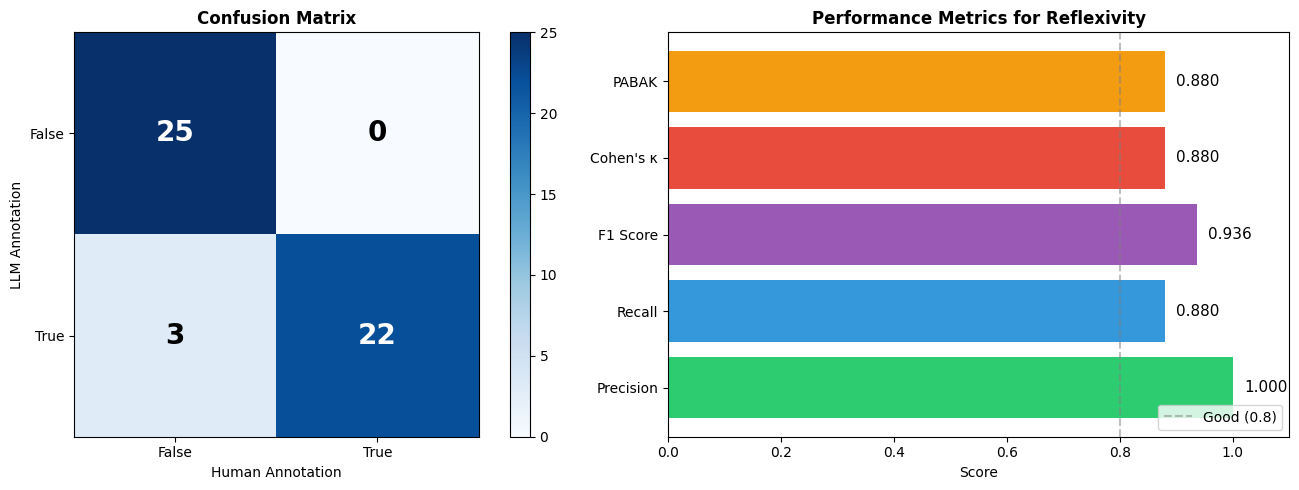


✓ Figure saved as: is_reflexive_iaa_analysis.png


In [32]:
# ============================================
# ALTERNATIVE: More detailed visualization
# ============================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Left: Confusion Matrix ---
ax1 = axes[0]
im = ax1.imshow(cm, interpolation='nearest', cmap='Blues')
cbar = ax1.figure.colorbar(im, ax=ax1)

ax1.set(xticks=[0, 1],
        yticks=[0, 1],
        xticklabels=['False', 'True'],
        yticklabels=['False', 'True'],
        xlabel='Human Annotation',
        ylabel='LLM Annotation')
ax1.set_title('Confusion Matrix', fontsize=12, fontweight='bold')

thresh = cm.max() / 2
for i in range(2):
    for j in range(2):
        ax1.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=20, fontweight='bold')

# --- Right: Metrics Bar Chart ---
ax2 = axes[1]
metrics = ['Precision', 'Recall', 'F1 Score', "Cohen's κ", 'PABAK']
values = [precision, recall, f1, kappa, pabak]
colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c', '#f39c12']

bars = ax2.barh(metrics, values, color=colors)
ax2.set_xlim(0, 1.1)
ax2.set_xlabel('Score')
ax2.set_title('Performance Metrics for Reflexivity', fontsize=12, fontweight='bold')

# Add value labels on bars
for bar, val in zip(bars, values):
    ax2.text(val + 0.02, bar.get_y() + bar.get_height()/2,
             f'{val:.3f}', va='center', fontsize=11)

# Add reference line at 0.8 (good threshold)
ax2.axvline(x=0.8, color='gray', linestyle='--', alpha=0.5, label='Good (0.8)')
ax2.legend(loc='lower right')

plt.tight_layout()
plt.savefig('is_reflexive_iaa_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Figure saved as: is_reflexive_iaa_analysis.png")

### 2. SCOPE_CLASSIFICATION: Confusion Matrix + Metrics

In [37]:
# ============================================
# SCOPE_CLASSIFICATION: Confusion Matrix + Metrics
# ============================================
from sklearn.metrics import cohen_kappa_score, confusion_matrix, classification_report

print("=" * 60)
print("SCOPE_CLASSIFICATION: Full Analysis")
print("=" * 60)

human_col = merged['scope_classification_human']
llm_col = merged['scope_classification_llm']

# --- Basic Agreement ---
agree = (human_col == llm_col).sum()
total = len(merged)
pct = agree / total * 100

print(f"\nAgreement: {agree}/{total} = {pct:.1f}%")

# --- Cohen's Kappa (unweighted) ---
kappa = cohen_kappa_score(human_col, llm_col)
print(f"Cohen's κ (unweighted): {kappa:.3f}")

# --- Cohen's Kappa (weighted - for ordinal data) ---
scope_map = {'MICRO': 0, 'MESO': 1, 'MACRO': 2}
human_num = human_col.map(scope_map)
llm_num = llm_col.map(scope_map)
kappa_weighted = cohen_kappa_score(human_num, llm_num, weights='linear')
print(f"Cohen's κ (weighted):   {kappa_weighted:.3f}")

# --- Confusion Matrix ---
print("\n" + "-" * 40)
print("CONFUSION MATRIX")
print("-" * 40)
labels = ['MICRO', 'MESO', 'MACRO']
cm = confusion_matrix(human_col, llm_col, labels=labels)

print("                Human=MICRO  Human=MESO  Human=MACRO")
print(f"LLM=MICRO          {cm[0,0]:<8}    {cm[0,1]:<8}    {cm[0,2]}")
print(f"LLM=MESO           {cm[1,0]:<8}    {cm[1,1]:<8}    {cm[1,2]}")
print(f"LLM=MACRO          {cm[2,0]:<8}    {cm[2,1]:<8}    {cm[2,2]}")

# --- Per-class metrics ---
print("\n" + "-" * 40)
print("PER-CLASS METRICS (Precision, Recall, F1)")
print("-" * 40)
print(classification_report(human_col, llm_col, labels=labels, digits=3))

# --- PABAK ---
pabak = 2 * pct/100 - 1
print(f"PABAK: {pabak:.3f}")

# --- Disagreements ---
print("\n" + "-" * 40)
print("DISAGREEMENTS")
print("-" * 40)
disagree = merged[human_col != llm_col]
if len(disagree) > 0:
    for _, row in disagree.iterrows():
        print(f"  '{row['expression_human']}': Human={row['scope_classification_human']}, LLM={row['scope_classification_llm']}")
else:
    print("  None")

SCOPE_CLASSIFICATION: Full Analysis

Agreement: 48/50 = 96.0%
Cohen's κ (unweighted): 0.933
Cohen's κ (weighted):   0.952

----------------------------------------
CONFUSION MATRIX
----------------------------------------
                Human=MICRO  Human=MESO  Human=MACRO
LLM=MICRO          27          0           0
LLM=MESO           1           11          1
LLM=MACRO          0           0           10

----------------------------------------
PER-CLASS METRICS (Precision, Recall, F1)
----------------------------------------
              precision    recall  f1-score   support

       MICRO      0.964     1.000     0.982        27
        MESO      1.000     0.846     0.917        13
       MACRO      0.909     1.000     0.952        10

    accuracy                          0.960        50
   macro avg      0.958     0.949     0.950        50
weighted avg      0.963     0.960     0.959        50

PABAK: 0.920

----------------------------------------
DISAGREEMENTS
--------------

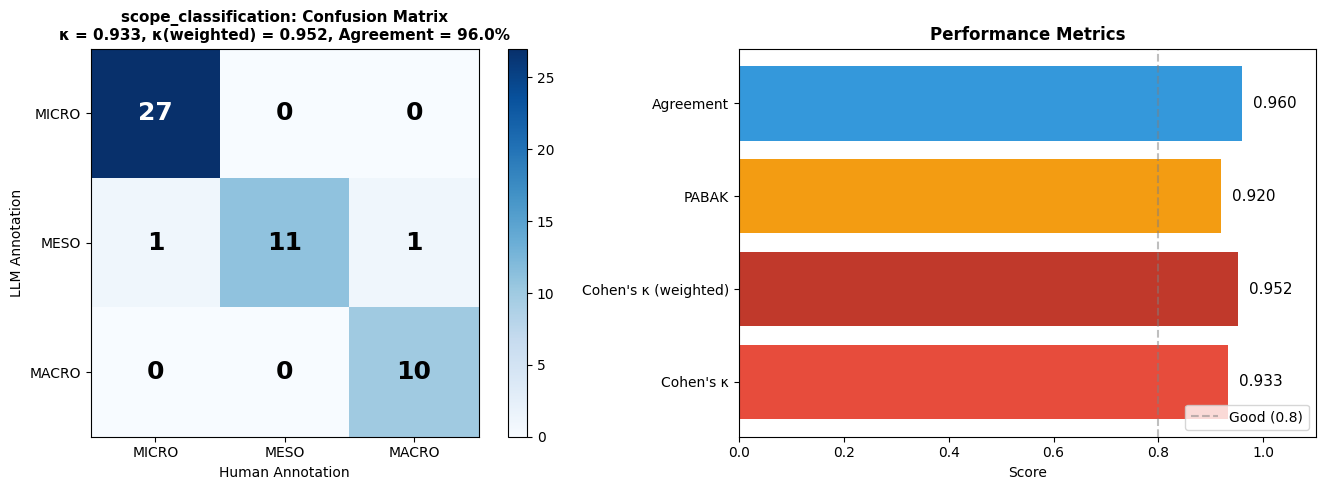


✓ Figure saved as: scope_classification_iaa_analysis.png


In [39]:
# ============================================
# VISUALIZE SCOPE CONFUSION MATRIX
# ============================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Left: Confusion Matrix ---
ax1 = axes[0]
im = ax1.imshow(cm, interpolation='nearest', cmap='Blues')
cbar = ax1.figure.colorbar(im, ax=ax1)

labels = ['MICRO', 'MESO', 'MACRO']
ax1.set(xticks=[0, 1, 2],
        yticks=[0, 1, 2],
        xticklabels=labels,
        yticklabels=labels,
        xlabel='Human Annotation',
        ylabel='LLM Annotation')
ax1.set_title(f'scope_classification: Confusion Matrix\nκ = {kappa:.3f}, κ(weighted) = {kappa_weighted:.3f}, Agreement = {pct:.1f}%',
              fontsize=11, fontweight='bold')

thresh = cm.max() / 2
for i in range(3):
    for j in range(3):
        ax1.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=18, fontweight='bold')

# --- Right: Metrics Bar Chart ---
ax2 = axes[1]
metrics = ["Cohen's κ", "Cohen's κ (weighted)", 'PABAK', 'Agreement']
values = [kappa, kappa_weighted, pabak, pct/100]
colors = ['#e74c3c', '#c0392b', '#f39c12', '#3498db']

bars = ax2.barh(metrics, values, color=colors)
ax2.set_xlim(0, 1.1)
ax2.set_xlabel('Score')
ax2.set_title('Performance Metrics', fontsize=12, fontweight='bold')

# Add value labels on bars
for bar, val in zip(bars, values):
    ax2.text(val + 0.02, bar.get_y() + bar.get_height()/2,
             f'{val:.3f}', va='center', fontsize=11)

# Add reference line at 0.8
ax2.axvline(x=0.8, color='gray', linestyle='--', alpha=0.5, label='Good (0.8)')
ax2.legend(loc='lower right')

plt.tight_layout()
plt.savefig('scope_classification_iaa_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Figure saved as: scope_classification_iaa_analysis.png")

In [7]:
def align_annotations(human_df, llm_df, id_column='sentence'):
    """
    Align human and LLM annotations based on a common identifier.
    If no id_column is specified, assumes same order and length.
    """
    if human_df is None or llm_df is None:
        return None, None, None

    if id_column and id_column in human_df.columns and id_column in llm_df.columns:
        # First, let's check how many sentences match exactly
        human_sentences = set(human_df[id_column])
        llm_sentences = set(llm_df[id_column])

        common_sentences = human_sentences.intersection(llm_sentences)
        only_human = human_sentences - llm_sentences
        only_llm = llm_sentences - human_sentences

        print(f"Sentence alignment analysis:")
        print(f"  - Total sentences in human data: {len(human_sentences)}")
        print(f"  - Total sentences in LLM data: {len(llm_sentences)}")
        print(f"  - Common sentences (exact matches): {len(common_sentences)}")
        print(f"  - Only in human data: {len(only_human)}")
        print(f"  - Only in LLM data: {len(only_llm)}")

        if len(common_sentences) == 0:
            print("\nNo exact sentence matches found. Let's check the first 10 sentences from each:")
            print("\nFirst 10 Human sentences:")
            for i, sent in enumerate(human_df[id_column].head(10)):
                print(f"  {i+1}: {sent[:100]}...")

            print("\nFirst 10 LLM sentences:")
            for i, sent in enumerate(llm_df[id_column].head(10)):
                print(f"  {i+1}: {sent[:100]}...")

            return None, None, None

        # Merge on sentence column
        merged = pd.merge(human_df, llm_df, on=id_column, suffixes=('_human', '_llm'))

        print(f"\nSuccessfully aligned {len(merged)} sentences!")

        # Show first 10 aligned sentences
        print("\nFirst 10 aligned sentences:")
        for i in range(min(10, len(merged))):
            print(f"{i+1}. Human: {merged['role_human'].iloc[i]} | LLM: {merged['role_llm'].iloc[i]}")
            print(f"   Sentence: {merged[id_column].iloc[i][:80]}...")
            print()

        return merged['role_human'], merged['role_llm'], merged
    else:
        print(f"Column '{id_column}' not found in one or both datasets")
        print("Human columns:", list(human_df.columns) if human_df is not None else "None")
        print("LLM columns:", list(llm_df.columns) if llm_df is not None else "None")

        # Fallback to positional alignment
        min_len = min(len(human_df), len(llm_df))
        return human_df['role'][:min_len], llm_df['role'][:min_len], None

# Try to align the data using sentence column
human_roles, llm_roles, merged_df = align_annotations(human_df, llm_df, id_column='sentence')

if human_roles is not None and llm_roles is not None:
    print(f"\nFinal aligned dataset size: {len(human_roles)}")

    # Create comparison DataFrame for analysis
    comparison_df = pd.DataFrame({
        'Human_Role': human_roles,
        'LLM_Role': llm_roles,
        'Agreement': human_roles == llm_roles
    })

    print(f"\nAlignment summary:")
    print(f"  - Total aligned annotations: {len(comparison_df)}")
    print(f"  - Perfect matches: {comparison_df['Agreement'].sum()}")
    print(f"  - Disagreements: {(~comparison_df['Agreement']).sum()}")
    print(f"  - Agreement rate (accuracy): {comparison_df['Agreement'].mean():.4f} ({comparison_df['Agreement'].mean()*100:.2f}%)")

else:
    print("Could not align the datasets. Please check data loading and column names.")

Sentence alignment analysis:
  - Total sentences in human data: 24
  - Total sentences in LLM data: 24
  - Common sentences (exact matches): 24
  - Only in human data: 0
  - Only in LLM data: 0

Successfully aligned 27 sentences!

First 10 aligned sentences:
1. Human: Metadiscourse | LLM: Metadiscourse
   Sentence: This thesis focuses on ‘text as an instrument’ and aims to reveal the generic st...

2. Human: Metadiscourse | LLM: Metadiscourse
   Sentence: This study takes the standpoint that genre is ‘a staged, goal oriented, purposef...

3. Human: Borderline | LLM: Borderline
   Sentence: Scacci (2011) states, ‘genres exist in relation to certain situational constrain...

4. Human: Metadiscourse | LLM: Metadiscourse
   Sentence: The present study aims to fill this gap within studies of this particular genre....

5. Human: Metadiscourse | LLM: Metadiscourse
   Sentence: Below, Figure 1.1 visualises this:...

6. Human: Metadiscourse | LLM: Metadiscourse
   Sentence: This introductory ch

In [8]:
# Calculate agreement metrics
if human_roles is not None and llm_roles is not None:
    # Remove any NaN values
    valid_indices = pd.notna(human_roles) & pd.notna(llm_roles)
    human_clean = human_roles[valid_indices]
    llm_clean = llm_roles[valid_indices]

    print(f"Valid annotations for comparison: {len(human_clean)}")

    # 1. Raw Agreement (Accuracy)
    accuracy = accuracy_score(human_clean, llm_clean)
    print(f"\n1. Raw Agreement (Accuracy): {accuracy:.4f} ({accuracy*100:.2f}%)")

    # 2. Cohen's Kappa
    kappa = cohen_kappa_score(human_clean, llm_clean)
    print(f"2. Cohen's Kappa: {kappa:.4f}")

    # Kappa interpretation
    if kappa < 0:
        kappa_interp = "Poor (worse than chance)"
    elif kappa < 0.2:
        kappa_interp = "Slight"
    elif kappa < 0.4:
        kappa_interp = "Fair"
    elif kappa < 0.6:
        kappa_interp = "Moderate"
    elif kappa < 0.8:
        kappa_interp = "Substantial"
    else:
        kappa_interp = "Almost Perfect"

    print(f"   Interpretation: {kappa_interp}")

    # 3. Per-class metrics
    print("\n3. Detailed Classification Report:")
    print(classification_report(human_clean, llm_clean, zero_division=0))

else:
    print("Cannot calculate metrics - data not available")

Valid annotations for comparison: 27

1. Raw Agreement (Accuracy): 0.9630 (96.30%)
2. Cohen's Kappa: 0.9302
   Interpretation: Almost Perfect

3. Detailed Classification Report:
               precision    recall  f1-score   support

   Borderline       1.00      1.00      1.00        10
Metadiscourse       1.00      0.94      0.97        16
Propositional       0.50      1.00      0.67         1

     accuracy                           0.96        27
    macro avg       0.83      0.98      0.88        27
 weighted avg       0.98      0.96      0.97        27



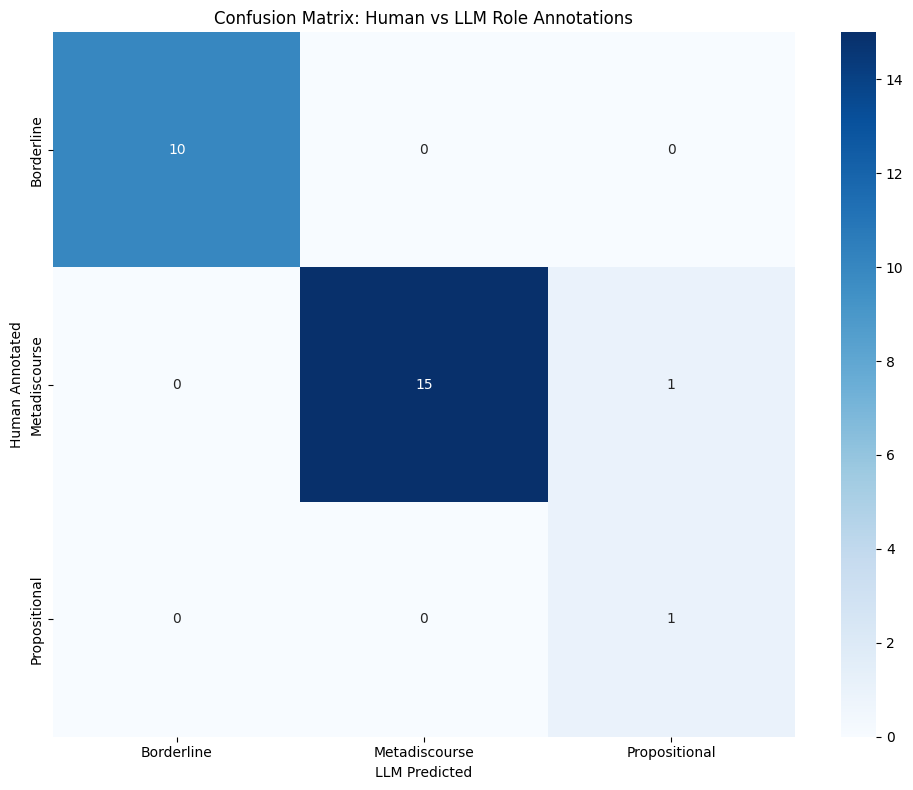

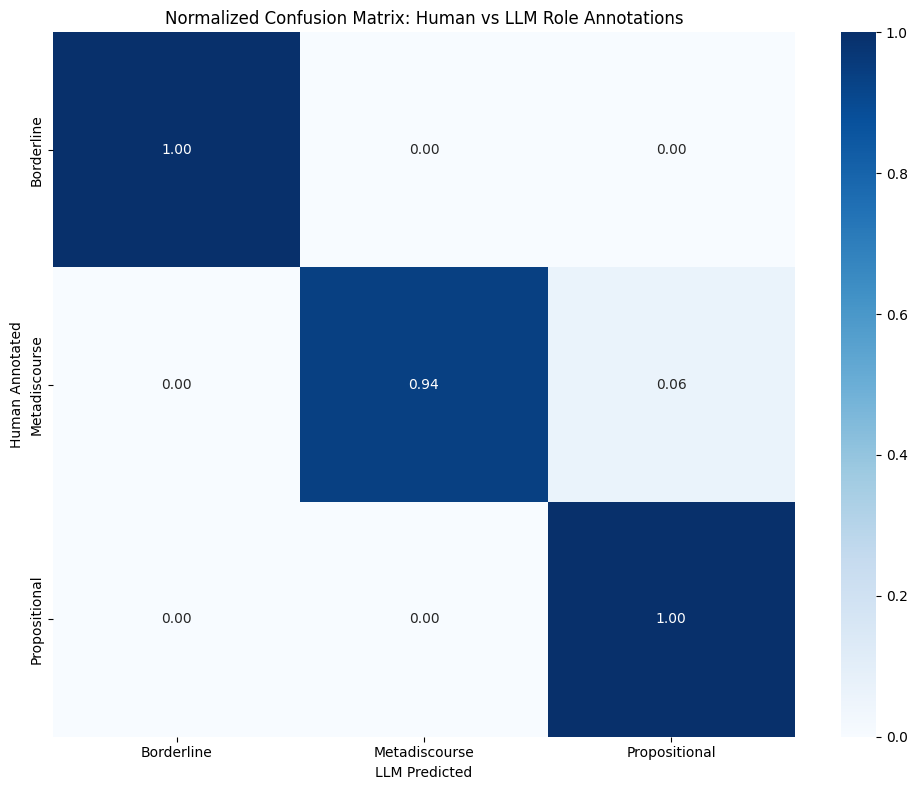

In [36]:
# Create confusion matrix and visualizations
if human_roles is not None and llm_roles is not None:
    # Confusion Matrix
    cm = confusion_matrix(human_clean, llm_clean)
    labels = sorted(list(set(human_clean) | set(llm_clean)))

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix: Human vs LLM Role Annotations')
    plt.xlabel('LLM Predicted')
    plt.ylabel('Human Annotated')
    plt.tight_layout()
    plt.show()

    # Normalized confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title('Normalized Confusion Matrix: Human vs LLM Role Annotations')
    plt.xlabel('LLM Predicted')
    plt.ylabel('Human Annotated')
    plt.tight_layout()
    plt.show()

Agreement rates by Human-annotated role:
               Total_Count  Agreements  Agreement_Rate
Human                                                 
Borderline              10          10          1.0000
Propositional            1           1          1.0000
Metadiscourse           16          15          0.9375


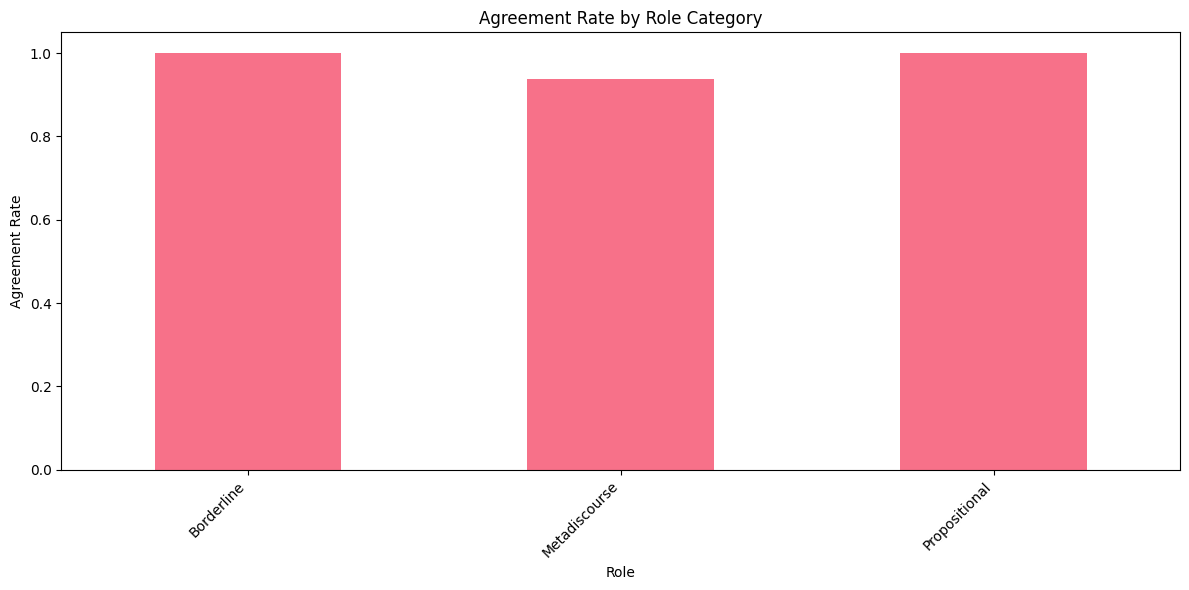


Total disagreements: 1

Most common disagreement patterns:
Human          LLM          
Metadiscourse  Propositional    1
dtype: int64


In [9]:
# Analyze agreement by role category
if human_roles is not None and llm_roles is not None:
    # Create agreement analysis by role
    agreement_df = pd.DataFrame({
        'Human': human_clean,
        'LLM': llm_clean,
        'Agreement': human_clean == llm_clean
    })

    # Agreement by human role
    role_agreement = agreement_df.groupby('Human')['Agreement'].agg(['count', 'sum', 'mean']).round(4)
    role_agreement.columns = ['Total_Count', 'Agreements', 'Agreement_Rate']

    print("Agreement rates by Human-annotated role:")
    print(role_agreement.sort_values('Agreement_Rate', ascending=False))

    # Visualize agreement rates
    plt.figure(figsize=(12, 6))
    role_agreement['Agreement_Rate'].plot(kind='bar')
    plt.title('Agreement Rate by Role Category')
    plt.xlabel('Role')
    plt.ylabel('Agreement Rate')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Disagreement analysis
    disagreements = agreement_df[agreement_df['Agreement'] == False]
    if len(disagreements) > 0:
        print(f"\nTotal disagreements: {len(disagreements)}")
        print("\nMost common disagreement patterns:")
        disagreement_patterns = disagreements.groupby(['Human', 'LLM']).size().sort_values(ascending=False)
        print(disagreement_patterns.head(10))
    else:
        print("\nNo disagreements found - perfect agreement!")

In [38]:
# Test statistical significance of agreement
if human_roles is not None and llm_roles is not None:
    # Chi-square test for independence
    chi2, p_value, dof, expected = chi2_contingency(cm)

    print(f"Chi-square test for independence:")
    print(f"Chi-square statistic: {chi2:.4f}")
    print(f"p-value: {p_value:.4e}")
    print(f"Degrees of freedom: {dof}")

    if p_value < 0.05:
        print("Result: Significant association between human and LLM annotations (p < 0.05)")
    else:
        print("Result: No significant association between human and LLM annotations (p >= 0.05)")

    # Calculate expected agreement by chance
    human_dist = pd.Series(human_clean).value_counts(normalize=True)
    llm_dist = pd.Series(llm_clean).value_counts(normalize=True)

    chance_agreement = sum(human_dist.get(role, 0) * llm_dist.get(role, 0)
                          for role in set(human_clean) | set(llm_clean))

    print(f"\nExpected agreement by chance: {chance_agreement:.4f} ({chance_agreement*100:.2f}%)")
    print(f"Observed agreement: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Improvement over chance: {(accuracy - chance_agreement):.4f} ({(accuracy - chance_agreement)*100:.2f} percentage points)")

Chi-square test for independence:
Chi-square statistic: 39.6562
p-value: 5.0981e-08
Degrees of freedom: 4
Result: Significant association between human and LLM annotations (p < 0.05)

Expected agreement by chance: 0.4691 (46.91%)
Observed agreement: 0.9630 (96.30%)
Improvement over chance: 0.4938 (49.38 percentage points)


In [42]:
# Generate summary report
if human_roles is not None and llm_roles is not None:
    print("=" * 60)
    print("INTER-ANNOTATOR AGREEMENT SUMMARY REPORT")
    print("=" * 60)

    print(f"Dataset Information:")
    print(f"  - Total aligned annotations: {len(human_clean)}")
    print(f"  - Unique roles in human data: {len(human_clean.unique())}")
    print(f"  - Unique roles in LLM data: {len(llm_clean.unique())}")

    print(f"\nAgreement Metrics:")
    print(f"  - Raw Agreement (Accuracy): {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"  - Cohen's Kappa: {kappa:.4f} ({kappa_interp})")
    print(f"  - Agreement over chance: +{(accuracy - chance_agreement)*100:.2f} percentage points")

    if len(disagreements) > 0:
        print(f"\nDisagreement Analysis:")
        print(f"  - Total disagreements: {len(disagreements)}")
        print(f"  - Disagreement rate: {(1-accuracy)*100:.2f}%")

    print(f"\nStatistical Significance:")
    if p_value < 0.05:
        print(f"  - Significant association found (p < 0.05)")
    else:
        print(f"  - No significant association (p >= 0.05)")

    print(f"\nRecommendations:")
    if kappa > 0.6:
        print(f"  - Agreement is substantial/strong. LLM annotations are reliable.")
    elif kappa > 0.4:
        print(f"  - Agreement is moderate. Consider reviewing disagreement patterns.")
    else:
        print(f"  - Agreement is low. LLM may need retraining or prompt refinement.")

    print("=" * 60)
else:
    print("Cannot generate summary - data not loaded properly.")
    print("Please check file paths and formats in the data loading section.")

INTER-ANNOTATOR AGREEMENT SUMMARY REPORT
Dataset Information:
  - Total aligned annotations: 27
  - Unique roles in human data: 3
  - Unique roles in LLM data: 3

Agreement Metrics:
  - Raw Agreement (Accuracy): 0.9630 (96.30%)
  - Cohen's Kappa: 0.9302 (Almost Perfect)
  - Agreement over chance: +49.38 percentage points

Disagreement Analysis:
  - Total disagreements: 1
  - Disagreement rate: 3.70%

Statistical Significance:
  - Significant association found (p < 0.05)

Recommendations:
  - Agreement is substantial/strong. LLM annotations are reliable.


In [43]:
# Export detailed results to CSV
if human_roles is not None and llm_roles is not None:
    # Create detailed comparison dataframe
    results_df = pd.DataFrame({
        'Human_Role': human_clean,
        'LLM_Role': llm_clean,
        'Agreement': human_clean == llm_clean
    })

    # Add index for reference
    results_df['Index'] = range(len(results_df))

    # Save results
    results_df.to_csv('agreement_analysis_results.csv', index=False)
    print("Detailed results saved to 'agreement_analysis_results.csv'")

    # Save summary metrics
    summary_metrics = {
        'Metric': ['Raw_Agreement', 'Cohens_Kappa', 'Total_Samples', 'Disagreements', 'Chi_Square_p_value'],
        'Value': [accuracy, kappa, len(human_clean), len(disagreements), p_value]
    }

    summary_df = pd.DataFrame(summary_metrics)
    summary_df.to_csv('agreement_summary_metrics.csv', index=False)
    print("Summary metrics saved to 'agreement_summary_metrics.csv'")

    print("\nAnalysis complete!")
else:
    print("Cannot export results - data not loaded properly.")

Detailed results saved to 'agreement_analysis_results.csv'
Summary metrics saved to 'agreement_summary_metrics.csv'

Analysis complete!
